### Sage Health Coronavirus Deep Learning Competition ###

#### Method Description: ####

Our approach is an adaptation of [Deep Reinforcement Learning for de-novo Drug Design](https://github.com/isayev/ReLeaSE). The idea is to first train a generative Recurrent Neural Network (Stack-RNN) on 1.5 million structures on ChEMBL22, then fine-tune the generative RNN with Reinforcement Learning using the binding affinity score of the generated ligand with [6LU7 3C Protease](https://www.rcsb.org/structure/6LU7) as reward.

We use [AutoDock Vina](http://vina.scripps.edu/) to perform ligand-protein binding simulation. 

In [299]:
import sys
import datetime
import os
sys.path.append('./release/')

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR, StepLR
import torch.nn.functional as F

import numpy as np
from tqdm import tqdm, trange, tnrange, tqdm_notebook
import pickle
import subprocess
from rdkit import Chem, DataStructs

from rdkit import rdBase
rdBase.DisableLog('rdApp.error')

from stackRNN import StackAugmentedRNN
from data import GeneratorData
from utils import canonical_smiles

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [300]:
use_cuda = torch.cuda.is_available()

### Generative Model (Stacked-RNN) ##

Load Training Data for generative RNN model ([Stacked-RNN](https://arxiv.org/pdf/1503.01007.pdf)). As described in the [paper](https://advances.sciencemag.org/content/advances/4/7/eaap7885.full.pdf), Stacked-RNN is better than standard RNN implementations such as LSTM or GRU in its ability to capture long-term dependencies and count token occurrence.

Training data is from on 1.5 million structures on [ChEMBL22](https://www.ebi.ac.uk/chembl/)

In [301]:
gen_data_path = './data/chembl_22_clean_1576904_sorted_std_final.smi'

In [302]:
tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
          '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
          '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

In [303]:
gen_data = GeneratorData(training_data_path=gen_data_path, delimiter='\t',
                         cols_to_read=[0], keep_header=True, tokens=tokens)

### Load Pretrain Model for Stacked-RNN ### 

Initialize and load our Stacked-RNN model. We use the pretrained model made available from https://github.com/isayev/ReLeaSE. 

In [304]:
# Params for RNN Generator
hidden_size = 1500
stack_width = 1500
stack_depth = 200
layer_type = 'GRU'
lr = 0.001
optimizer_instance = torch.optim.Adadelta

In [305]:
my_generator = StackAugmentedRNN(input_size=gen_data.n_characters,
                                     hidden_size=hidden_size,
                                     output_size=gen_data.n_characters,
                                     layer_type=layer_type,
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=stack_width, stack_depth=stack_depth,
                                     use_cuda=use_cuda,
                                     optimizer_instance=optimizer_instance, lr=lr)

In [306]:
model_path = './checkpoints/generator/checkpoint_biggest_rnn'

my_generator.load_model(model_path)

### Reinforcement Learning to fine-tune ligand ###

First initialize our Reinforcement Learning Agent. It is a Vanilla Policy Gradient algorithm (REINFORCE)

In [307]:
from reinforcement import Reinforcement

In [308]:
# Params for RL
n_policy = 30
n_iterations = 100
n_batch = 10

File to save our most promising ligands with the highest binding scores   

In [309]:
top_ligands_file = "top_ligands.txt"

if os.path.exists(top_ligands_file):
    os.remove(top_ligands_file)

### Reward Function for RL Training ###

Reward for RL training is a function of the binding affinity score between our generated ligand and the 3C Protease receptor generated by [AutoDock Vina](http://vina.scripps.edu/). 

We first downloaded the 3C Protease pdb structure from https://www.rcsb.org/structure/6LU7. Since the 6LU7 structure comes together with the N3 inhibitor, we have to first seperate it out by manually examining the protein pdb file and extract the lines with keyword "ATOM" in it. The resulting file was saved as `receptor.pdbqt`, a format that is compatible with AutoDock Vina.

To identify the binding site of the target protein, we loaded the 6LU7 pdb structure into [PyMol](https://pymol.org/2/) and used the tool to draw up a bounding box that contains the potential binding site, identified by the region of the protein that binds to the N3 inhibitor.

Once we obtain the bounding box for the binding site, we fed the information to AutoDock Vina to conduct docking simulation. The exhaustiveness value was set to 3 to speed up the search. AutoDock Vina usually returns a few binding affinity value. We only take the first one (with the largest negative value) as a proxy for how well the ligand-protein binding goes.

The final reward for the Reinforcement Learning algo is a function of the binding affinity score. We shape the reward such that the signal for good binding score is stronger.  

In [316]:
def get_docking_reward(smile):
    """
    Reward function for RL. Use AutoDock Vina to simulate binding affinity of our ligand with receptor protein. Use binding affinity as reward to train the RL agent
    """

    #vina --receptor receptor.pdbqt --ligand ligand.pdbqt --log dock.log --exhaustiveness 3 --center_x -10 --center_y 10 --center_z 70 --size_x 10 --size_y 15 --size_z 15
    vina_cmd = ['./vina','--receptor','receptor.pdbqt','--ligand','ligand.pdbqt','--log','dock.log','--exhaustiveness','3','--center_x','-10','--center_y','10','--center_z','70','--size_x','10','--size_y','15','--size_z','15']
    
    # Check SMILE validity
    binding_score = -1.0 # Penalty for invalid SMILES
    if Chem.MolFromSmiles(smile) is None:
        return binding_score
    else:
        # Transform SMILES to pdbqt
        if os.path.exists('ligand.smi'):
            os.remove('ligand.smi')
        if os.path.exists('ligand.pdbqt'):
            os.remove('ligand.pdbqt')
        with open('ligand.smi', 'w') as f:
            f.write(smile)
        babel_cmd = ['babel','ligand.smi','ligand.pdbqt','--gen3D']
        out = subprocess.Popen(babel_cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
        out.communicate()
        out = subprocess.Popen(vina_cmd, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
        out.communicate()
        with open('dock.log', 'r') as f:
            for line in f:
                if "  1  " in line:
                    binding_score = line.split('      ')[1].strip()
        try:
            binding_score = -float(binding_score)
        except:
            pass
        
    # Strengthen the reward for good binding score
    reward = 0.0
    if binding_score > 6.0:
        reward = 50.0
    elif binding_score > 5.5:
        reward = 40.0
    elif binding_score > 5.0:
        reward = 30.0
    elif binding_score > 4.5:
        reward = 10.0
    else:
        reward = -1.0
        
    # Save ligand with reward >= 5.0
    if binding_score > 4.5:
        with open(top_ligands_file, "a+") as f:
            f.write(smile + "," + str(binding_score) + "," + str(reward) + "\n")

    return reward

In [317]:
def simple_moving_average(previous_values, new_value, ma_window_size=10):
    value_ma = np.sum(previous_values[-(ma_window_size-1):]) + new_value
    value_ma = value_ma/(len(previous_values[-(ma_window_size-1):]) + 1)
    return value_ma

### Main Loop for RL (Train for 24 hours) ###

In [ ]:
RL_agent = Reinforcement(my_generator, get_docking_reward)

rewards = []
train_duration = 24*60*60 # 24 hours

start_time = datetime.datetime.now()

train_flag = True
for i in range(n_iterations):
    if train_flag:
        for j in tnrange(n_policy, desc='Policy gradient...'):
            new_reward, _ = RL_agent.policy_gradient(gen_data, n_batch)
            rewards.append(simple_moving_average(rewards, new_reward))
            time_elapsed = datetime.datetime.now() - start_time
            if time_elapsed.seconds > train_duration:
                print("Training exceed train duration!")
                train_flag = False
                break
    else:
        break
        
    plt.plot(rewards)
    plt.xlabel('Training iteration')
    plt.ylabel('Average reward')
    plt.show()

### Draw Up Top 20 Ligands ###

We pick the 20 ligands with the top 20 binding affinity score and draw them

In [293]:
ligand_list = []
with open(top_ligands_file, "r") as f:
    for line in f:
        row_list = line.split(",")
        ligand_list.append({
            "smile": row_list[0],
            "binding_score": float(row_list[1])
        })
        
ligand_list = sorted(ligand_list, key=lambda x: x["binding_score"], reverse=True)

top_k = 20
top_ligands = []
top_scores = []
print("Top 20 Ligands:" + "\n")
for i, ligand in enumerate(ligand_list):
    if i < top_k:
        top_ligands.append(ligand["smile"])
        top_scores.append(ligand["binding_score"])
        print("SMILE: " + ligand["smile"])
        print("Affinity Score: " + str(ligand["binding_score"]) + "\n")

Top 20 Ligands:

SMILE: CNc1nc(C)nc2ccc(cc12)C(=O)NCCCCCN(C(C)=O)c1ccccc1
Affinity Score: 5.5

SMILE: FC(F)(F)c1ccc2ncnc(Nc3ccc(Cl)nc3-c3ccc(CN4CCOCC4)c(c3)C#N)c2c1
Affinity Score: 5.1

SMILE: N1c2c(Sc3ncccc3N3CCN(CC3)c3ccccc3F)ncnc2-c2ccccc12
Affinity Score: 5.1

SMILE: Clc1ccccc1CN1CC(CC1=O)n1ncc2c1ccnc2c1ccc(Cl)cc1Cl
Affinity Score: 5.1

SMILE: FC(F)Oc1ccc(CNC(=O)CCc2cccc(Cl)c2)cc1
Affinity Score: 4.8

SMILE: CC(C)CN(C)C(=O)C1CCCN(CCc2ccc(cc2)-c2ccc(F)cc2)C1
Affinity Score: 4.8

SMILE: CCOC(=O)C1CCCN(C1)C(=O)CSC1=NC(=O)c2c(N1)cccc2C
Affinity Score: 4.8



In [284]:
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

In [285]:
generated_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in top_ligands]

In [286]:
sanitized_gen_mols = [generated_mols[i] for i in np.where(np.array(generated_mols) != None)[0]]

In [287]:
legends = ['Binding Score = ' + str(top_scores[i]) for i in range(len(top_scores))]

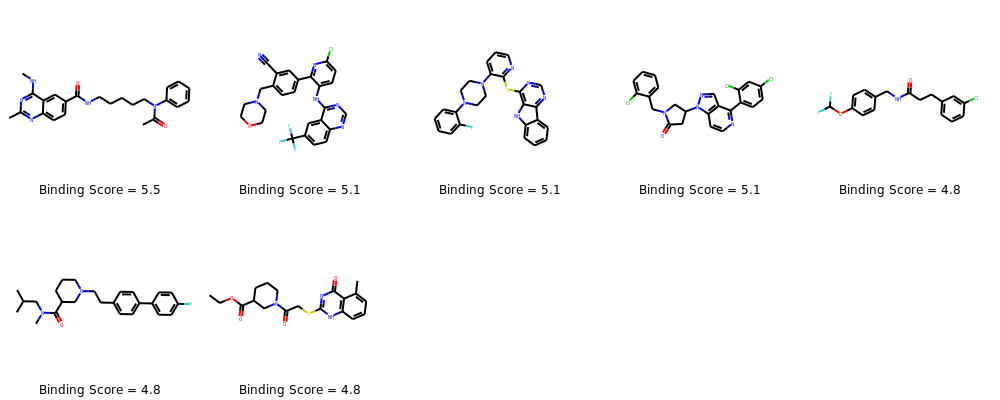

In [288]:
Draw.MolsToGridImage(sanitized_gen_mols, molsPerRow=5, 
                     subImgSize=(200,200), legends=legends)

### Conclusion and Evaluation ###

To conclude, we were able to put together a pipeline that successfully leveraged reinforcement learning to generate candidate ligands that exhibit good binding affinity with 3C Protease. We are well aware of the fact that there exists a discrepancy between computer simulator and real laboratory environment. Given little time for this competition, we hope this work will serve as a good starting point to explore further. In particular, we want to further explore the following ideas:   

#### 1) Improvement in RL algo ####

The RL algo took a long time to converge and also exhibited a high variance. We can consider using some other more advanced methods such as [Proximal Policy Optimization](https://openai.com/blog/openai-baselines-ppo/) which is more stable and usually converges faster as compared to REINFORCE. 

Since docking simulation by AutoDock Vina is slow, we can consider using a more data efficient algo such as [Soft Actor Critic](https://arxiv.org/abs/1801.01290), another easy to use off-the-shelf RL algo. Since it's an off-policy algo, simulated data can be stored and reused.

#### 2) Domain Expert ####

Domain expert knowledge could potentially be incorporated to come up with a better reward function for training the RL agent. For example, a reward function that encourages molecular diversity, chemical properties such as number of desired bonds / rings structures, certain restrictions in the molecular weights, etc.  



